## Introduction

This tutorial will introduce you to some basic methods for processing X-ray diffraction data, particularly focusing on Laue diffraction data.  Laue diffraction is a significant characterization tool that can investigate the crystals' orientation and strain field, thus it has been widely used in materials science and physics field. In many settings, we raster the x-ray beam across the materials, the grains illuminated by the x-ray will generate Laue patterns on the detector and each Laue pattern consists of many peaks. The picture below shows the simplified geometry of Laue diffraction.

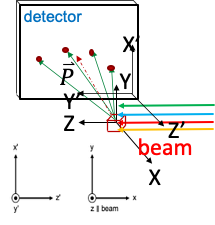

In many settings we want to visualize or analyze Laue pattern on the detector: where diffraction peaks located can provide us important information of materials under investigation. The relation between the positions of the peaks and materials properties is beyond the tutorial and we will not discuss it here. However, we need to stress this - how to extract the peaks from the image is a very important issue and makes a huge difference for the analysis later. Sometimes this involves constant trials of thresholding values to get rid of the noise but sometimes feature extraction tells us a great deal about some questions we are interested in. 

Among other feature extraction packages, we will use Xlearn as a tool to help us segment the peaks! Xlearn is an open-source Python package implementing Convolutional Neural Networks (CNN) for X-ray Science. Inside the package, there is a feature extraction model which is called segmentation, and it is powerful for extracting the peaks.

Also, we will introduce a widely used package -- DXchange package, which provides an interface with TomoPy and raw tomographic data collected at synchrotron facilities, for example, 2-BM,32-ID, and 34-ID at the Advanced Photon Source (APS) beamline, at the Swiss Light Source Tomcat beamline and the Elettra SYRMEP beamline. 


### Tutorial content

In this tutorial, we will show how to do some basic segmentation analysis in X-ray diffraction data specifically using [Xlearn](https://xlearn.readthedocs.io/en/latest/index.html), [DXchange](https://dxchange.readthedocs.io/en/latest/).

We've collected Laue patterns from APS 34-ID-C and will use this dataset to explain the packages, and the analysis we do here could be repeated for many other diffraction images as well.

We will cover the following topics in this tutorial:
- Installing the libraries
- Loading data and plotting
- Model training (Training the xlearn-segmentation model)
- Model testing (Test the model on the unseen data and see the performance)
- Find the best parameters and weights (Parameters search)
- Model evaluation (Discuss the evolution of the performance via different parameters)
- Further source

## Installing the libraries

Before you started installing Xlearn and other libraries, you should install anaconda and tensorflow-gpu version. <br/>

1.Install anaconda: https://docs.anaconda.com/anaconda/install/.

&emsp;You should download the anaconda based on your operation system.
    
2.Install tensorflow: https://www.tensorflow.org/install/gpu.

&emsp;You should install the tensorflow-gpu version via `pip`. You also need to make sure that the cuda drivers and cudnn are correctly installed to your OS.<br/>
&emsp;**pip install tensorflow**
    
3.Install Xlearn package: Clone the xlearn from GitHub repository.<br/>
&emsp;**git clone https://github.com/tomography/xlearn.git xlearn**<br/>
&emsp;**cd xlearn**<br/>
&emsp;**python setup.py install**

4.After you installed anaconda, tensorflow-gpu and Xlearn, you need to install all the libraries below:<br/>
    &emsp;**conda install sys<br/>
    &emsp;conda install dxchange<br/>
    &emsp;conda install tifffile<br/>
    &emsp;conda install matplotlib<br/>
    &emsp;conda install numpy<br/>
    &emsp;conda install copy<br/>
    &emsp;conda install scipy<br/>
    &emsp;conda install pandas**<br/>
    
5.With all the libraries installed on your own computer, you should make sure the following commands work for you:

In [75]:
import sys
sys.path.append("/home/yuehengz/xlearn/")
from xlearn.segmentation import seg_train, seg_predict
import dxchange
import matplotlib.pyplot as plt

import tifffile as tfile
from tifffile import imsave
import numpy as np
import pandas as pd
import scipy

## Loading data and plotting

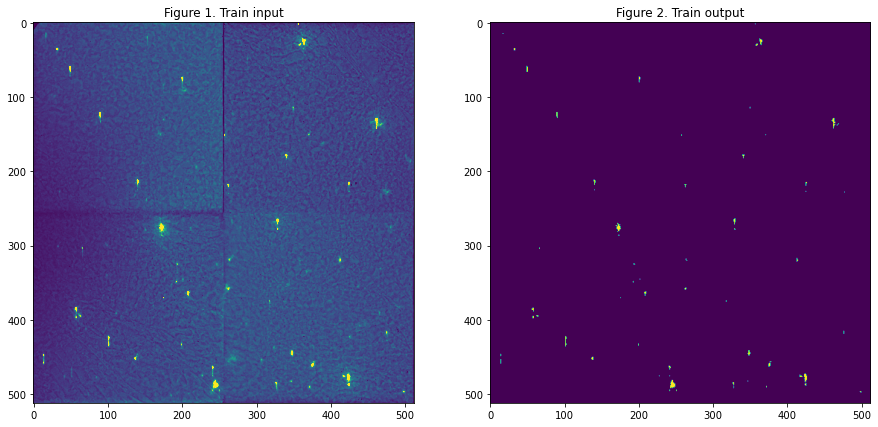

In [2]:
# training data path (input and output)
training_input = '/home/yuehengz/xlearn/test/test_data/ad_align_00201.tif'
training_output = '/home/yuehengz/xlearn/test/test_data/ad_align_00201.tif_processed.tif'
# plot the training data(input and output)
img_input = dxchange.read_tiff(training_input)
img_output = dxchange.read_tiff(training_output)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_input, cmap = 'viridis',vmax=10000)
plt.title('Figure 1. Train input')
plt.subplot(1,2,2)
plt.imshow(img_output, cmap = 'viridis',vmax=1)
plt.title('Figure 2. Train output')
plt.show()

Figure 1 is the input training data, and Figure 2 is the training output. As we can see here, the Laue peaks are the bright regions in Figure 1 and all of the peaks are mannually extracted and saved in the Figure 2. Train output. The main purpose of this segmentation is to get rid of the background noise and maintain the shape of the peaks (yellow regions in the figure 1). 

## Model Training 

We should train our segmentation model by using the function seg_train from xlearn.segmentation. This function has the following paramters: <br/>
- img_x: training input of the model, which refers to the raw image (img_input in the above cell). Type is 2D or 3D array.
- img_y: training output of the model, which refers to the segmentation result (img_output in the above cell). Type is 2D or 3D array.
- patch_size: The minimal size of the patches you consider to extract from the raw image. You should make this number big enough to capture the features of the objects. Type is int.
- patch_step: The step size between the patches. If you increase the stepsize, you will increase the speed but decrease the quality. Normally, we will use 1 when training. Type is int.
- nb_conv: The number of convolutional kernels of the first layer. Type is int.
- size_conv: The size of each convolutional kernel. Type is int.
- batch_size: The batch size is restricted by the memory size of the GPU. If you got a memory error, you should decrease the batch_size. Type is int.
- nb_epoch: The number of epochs/iterations for the training. You may need to increase the number of epochs to arrive at the convergence. Type is int.
- nb_down: The number of downsampling for the images. If we need to extract some small features, we should avoid making the number of the downsampling too big. Type is int.
- nb_gpu: The number of GPUs you use for the training. Type is int.

In [3]:
# define the initial parameters (you can change those parameters according to your dataset)
patch_size=32
patch_step=1
batch_size = 4000
nb_epoch = 20
nb_down = 1
nb_gpu = 4
# define the path to save the weights
weight = '/home/yuehengz/xlearn/test/test_data/weights_seg.h5'
# train the model
model = seg_train(img_input, img_output, patch_size=patch_size, patch_step=patch_step,
        batch_size=batch_size, nb_epoch=nb_epoch, nb_down=1,
        nb_gpu=4)
# save the trained weights
model.save_weights(weight)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


/home/yuehengz/.conda/envs/tf_gpu/lib/python3.8/site-packages/xlearn-0.3.0-py3.8.egg/xlearn/utils.py:227: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm

This shows the model training is complete and the loss can arrive at 8.4667e-05 after 20 iterations. The next step is to use the well trained model to test an unseen image and see how it works.

## Model testing

In [4]:
# read the testing data
img_test = dxchange.read_tiff('/home/yuehengz/xlearn/test/test_data/Staff21-1h_S0032_00027.tif')
# define the save path for the segmented image
save = '/home/yuehengz/xlearn/test/test_data'
# segmentation for the testing data
weight = '/home/yuehengz/xlearn/test/test_data/weights_seg.h5'
patch_size=32
patch_step=1
batch_size = 4000
nb_epoch = 20
nb_down = 1
nb_gpu = 4
seg_predict(img_test, weight, save, nb_down = nb_down, nb_gpu = nb_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


### Plot the test results

Text(0.5, 1.0, 'CNN Segmentation')

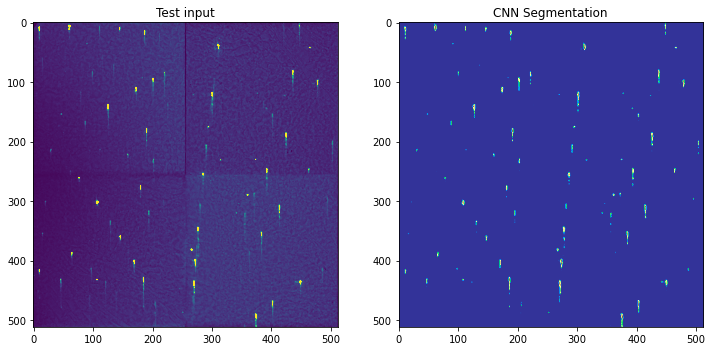

In [5]:
img_prd = dxchange.read_tiff('/home/yuehengz/xlearn/test/test_dataseg-3.tiff')
img_target = dxchange.read_tiff('/home/yuehengz/xlearn/test/test_data/Staff21-1h_S0032_00027.tif')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img_test, cmap = 'viridis',vmax=1e4)
plt.title('Test input')
plt.subplot(1,2,2)
plt.imshow(img_prd, cmap='terrain')
plt.title('CNN Segmentation')

As we can see the result (CNN Segmentation), it looks pretty good and can return us almost each peak in the test input. However, it seems that we are still missing some weak peaks (red circle in the following picture).
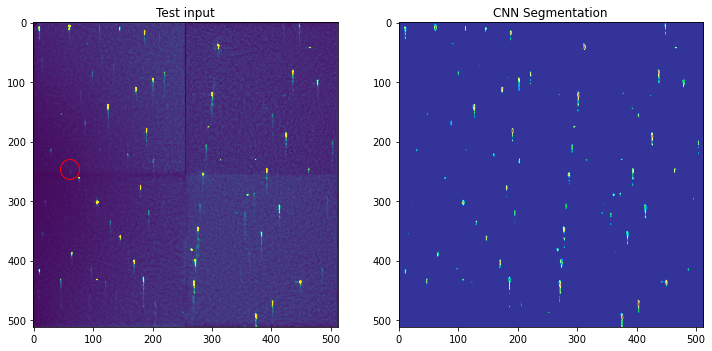

It is common in data science that we need to modify the model parameters to accomplish a better job. Thus, we will introduce the way we modified the parameters to find the missing peaks.  

We change the number of convolutional kernels of the first layer, the size of convolutional kernels, and the number of downsampling for the images. To visualize the combination of three parameters, we create a data frame via pandas and the combined result is below.


In [6]:
nb_conv = np.array([32,36,40])
size_conv = np.array([3,6,9])
nb_down = np.array([0,1,2])

aa,bb,cc = np.meshgrid(nb_conv,size_conv,nb_down,indexing='ij')
aa = aa.ravel()
bb = bb.ravel()
cc = cc.ravel()
d = {'nb_conv':aa,'size_conv':bb,'nb_down':cc}
df = pd.DataFrame(data=d)
df

nb_conv  size_conv  nb_down
0        32          3        0
1        32          3        1
2        32          3        2
3        32          6        0
4        32          6        1
5        32          6        2
6        32          9        0
7        32          9        1
8        32          9        2
9        36          3        0
10       36          3        1
11       36          3        2
12       36          6        0
13       36          6        1
14       36          6        2
15       36          9        0
16       36          9        1
17       36          9        2
18       40          3        0
19       40          3        1
20       40          3        2
21       40          6        0
22       40          6        1
23       40          6        2
24       40          9        0
25       40          9        1
26       40          9        2

In [7]:

for i in range(len(df)):
    print("nb_conv:",df.loc[i]['nb_conv'])
    print("size_conv:",df.loc[i]['size_conv'])
    print("nb_down:",df.loc[i]['nb_down'])
    # define the weight data path to be saved 
    save_path = '/home/yuehengz/xlearn/test/test_data/weights/'
    # define the name of each weight
    weight_path = save_path + 'weights_seg_%s.h5'%i
    
    # define all the parameters in the model
    patch_size=32
    patch_step=1
    nb_conv=df.loc[i]['nb_conv']
    size_conv=df.loc[i]['size_conv']
    batch_size=4000
    nb_epoch=20
    nb_down=df.loc[i]['nb_down']
    nb_gpu=4

    # train the model
    try:
        mdl = seg_train(img_input, img_output,patch_size=patch_size, patch_step=patch_step, nb_conv=nb_conv,
        size_conv=size_conv, batch_size=batch_size, nb_epoch=nb_epoch, nb_down=nb_down,
        nb_gpu=nb_gpu)
        # save the trained weights
        mdl.save_weights(weight_path)

    except:
        continue

nb_conv: 32
size_conv: 3
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


/home/yuehengz/.conda/envs/tf_gpu/lib/python3.8/site-packages/xlearn-0.3.0-py3.8.egg/xlearn/utils.py:227: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/20
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
58/58 [==============================] - 13s 123ms/step - loss: 0.0018
Epoch 2/20
58/58 [==============================] - 7s 123ms/step - loss: 0.0015
Epoch 3/20
58/58 [==============================] - 7s 124ms/step - loss: 0.0014
Epoch 4/20
58/58 [==============================] - 7s 127ms/step - loss: 0.0013
Epoch 5/20
58/58 [==============================] - 8s 132ms/step - loss: 7.5331e-04
Epoch 6/20
58/58 [==============================] - 7s 128ms/step - loss: 5.2592e-04
Epoch 7/20
58/58 [==============================] - 7s 129ms/step - loss: 3.8217e-04
Epoch 8/20
58/58 [==============================] - 8s 132ms/step - loss: 3.0760e-04
Epoch 9/20
58/58 [==============================] - 7s 129ms/step - loss: 2.6366e-04
Epoch 10/20
58/58 [==============================] - 8s 130ms/step - loss: 2.3

Well, training the model by using different combinations of nb_conv, size_conv and nb_down can result in different losses. When nb_conv = 40, size_conv = 6 and nb_down =1, we can get the lowest loss 6.3357e-05, which is lower than the initial loss (8.4667e-05). However, the lowest loss in the training dataset can not guarantee that we get the best parameters for the model when dealing with other data. Thus, we still need to use another unseen dataset to find the best model. To find the best combination of parameters, we should use all the weights/models to segment data we used for testing, thus visualize the results is helpful. The following cell is visualization result for test data.

nb_conv: 32
size_conv: 3
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


/home/yuehengz/.conda/envs/tf_gpu/lib/python3.8/site-packages/xlearn-0.3.0-py3.8.egg/xlearn/utils.py:227: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


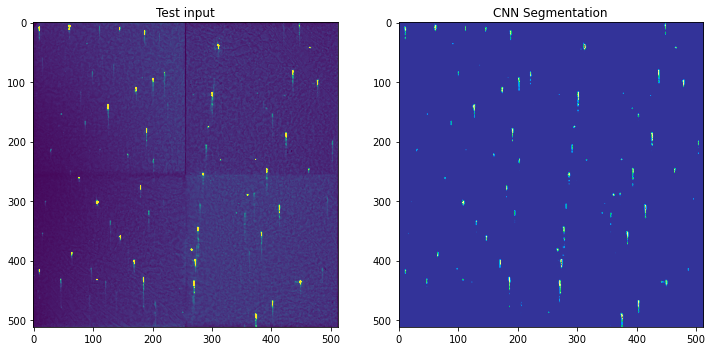

nb_conv: 32
size_conv: 3
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


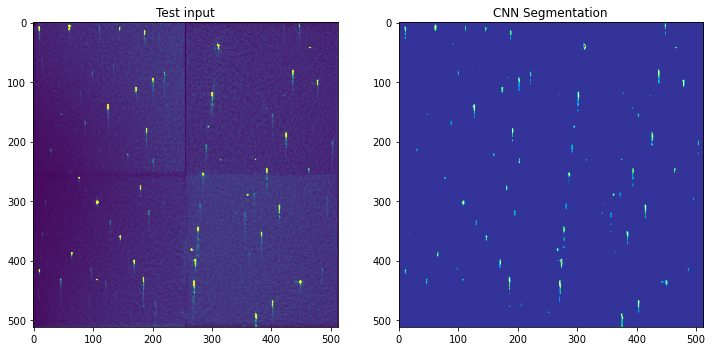

nb_conv: 32
size_conv: 3
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


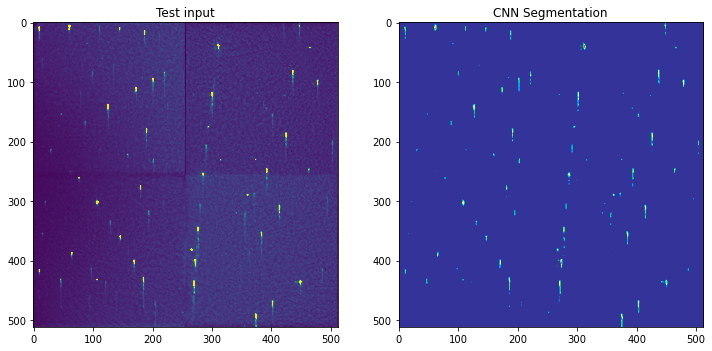

nb_conv: 32
size_conv: 6
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


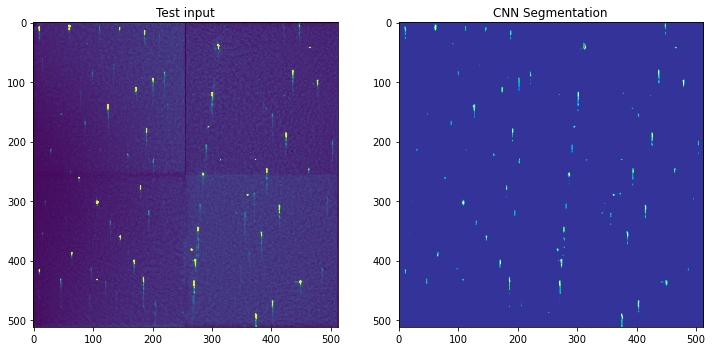

nb_conv: 32
size_conv: 6
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


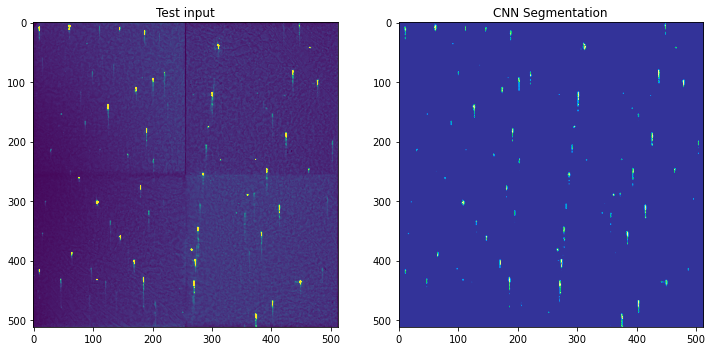

nb_conv: 32
size_conv: 6
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


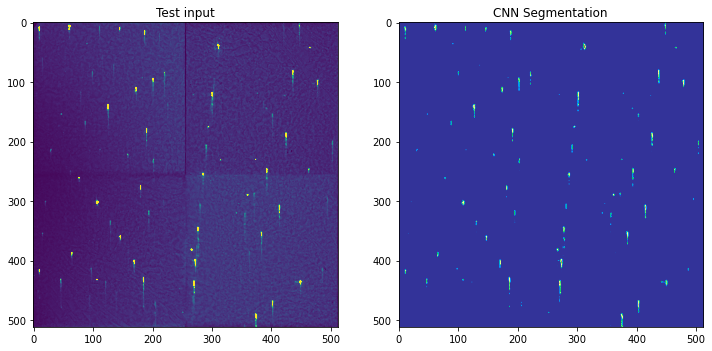

nb_conv: 32
size_conv: 9
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


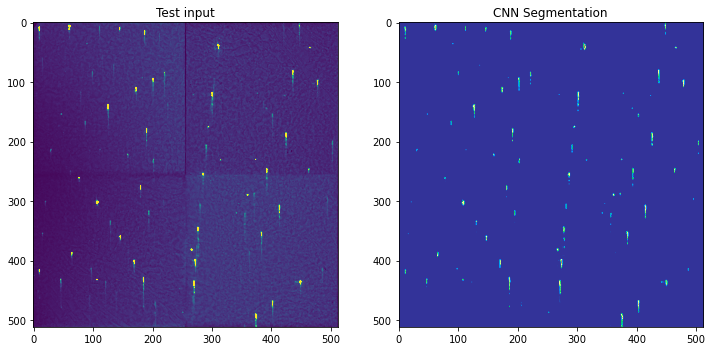

nb_conv: 32
size_conv: 9
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


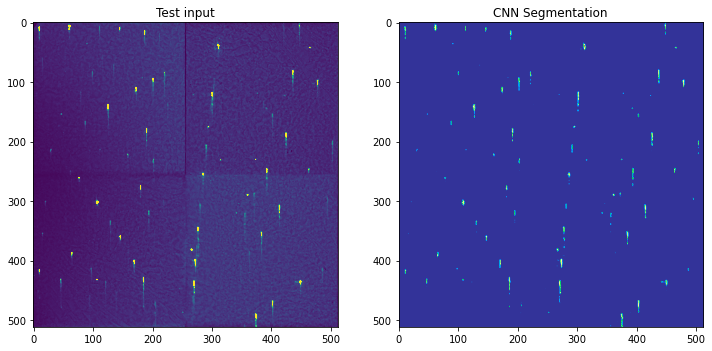

nb_conv: 32
size_conv: 9
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


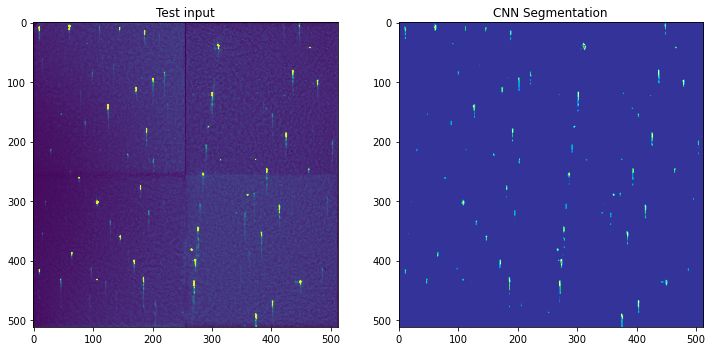

nb_conv: 36
size_conv: 3
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


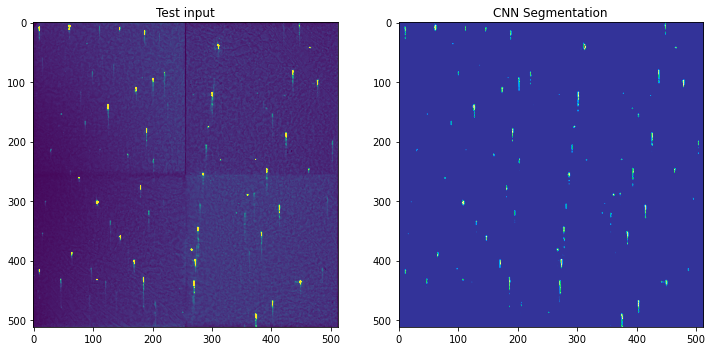

nb_conv: 36
size_conv: 3
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


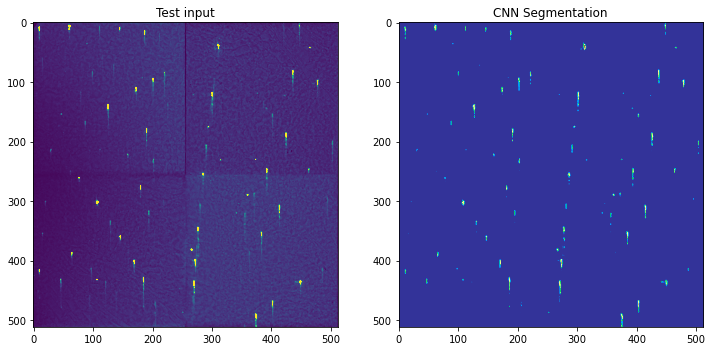

nb_conv: 36
size_conv: 3
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


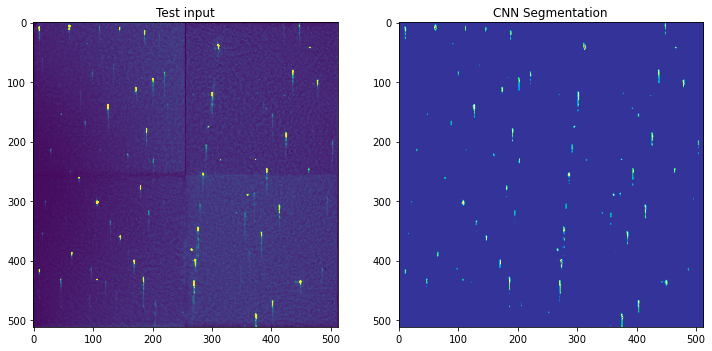

nb_conv: 36
size_conv: 6
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


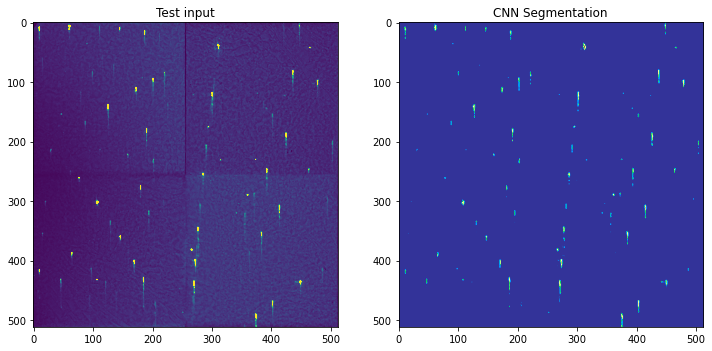

nb_conv: 36
size_conv: 6
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


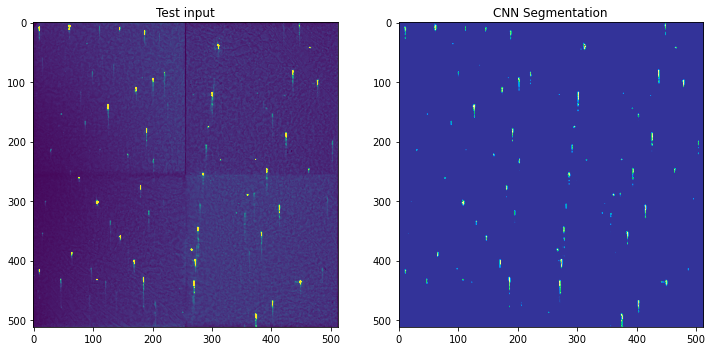

nb_conv: 36
size_conv: 6
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


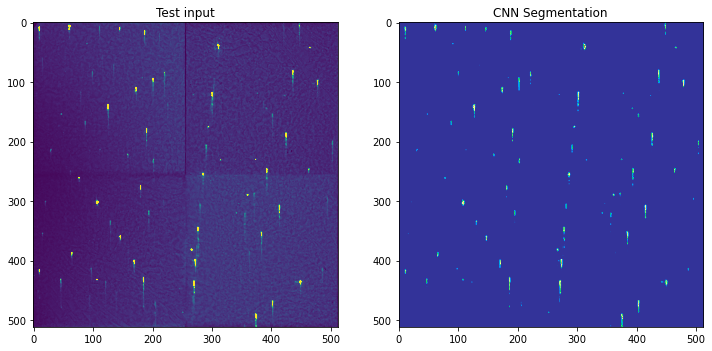

nb_conv: 36
size_conv: 9
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


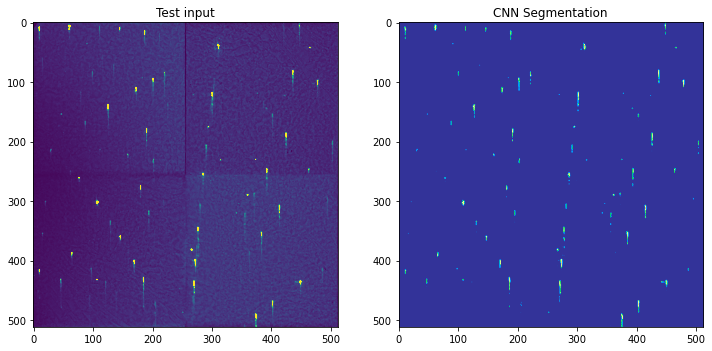

nb_conv: 36
size_conv: 9
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


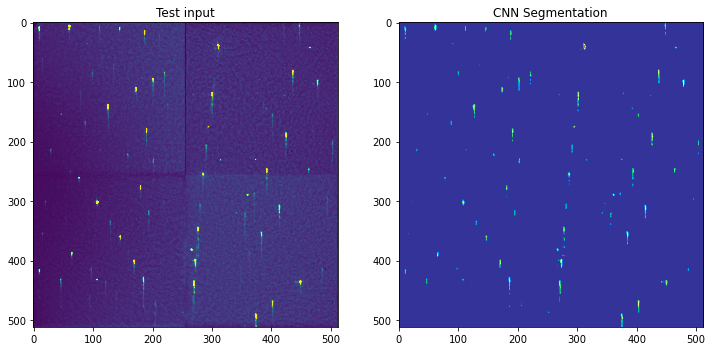

nb_conv: 36
size_conv: 9
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


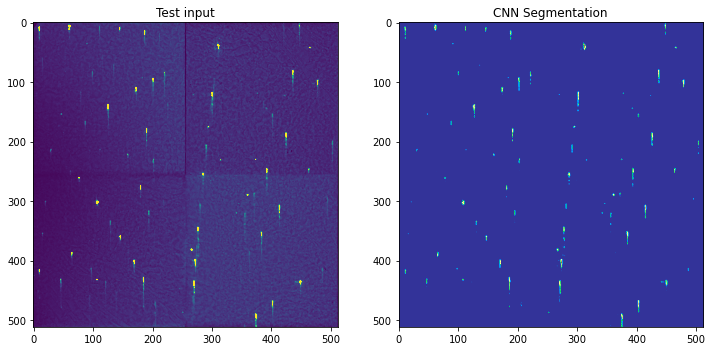

nb_conv: 40
size_conv: 3
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


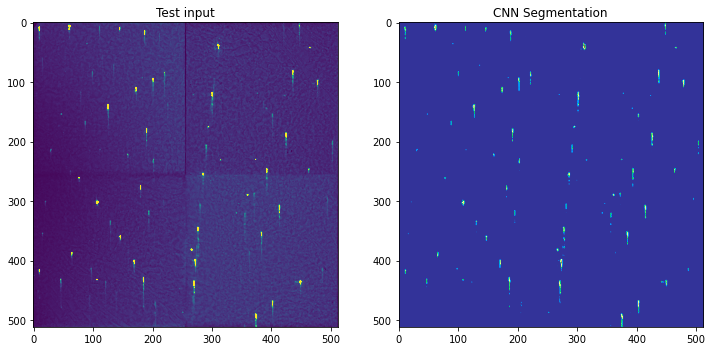

nb_conv: 40
size_conv: 3
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


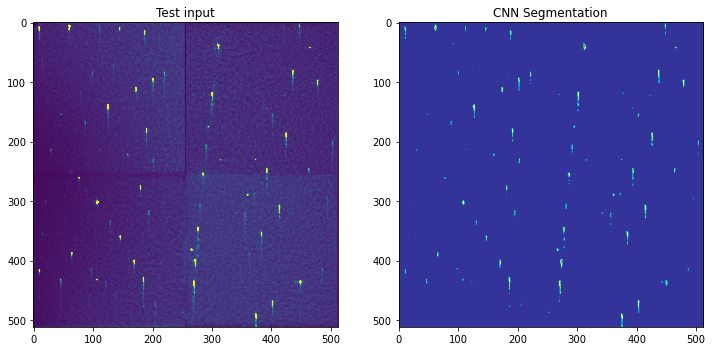

nb_conv: 40
size_conv: 3
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


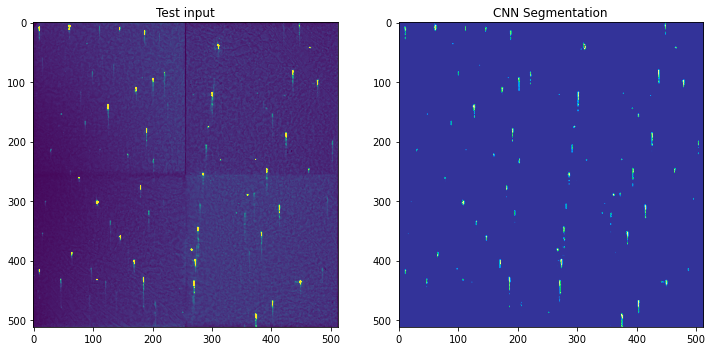

nb_conv: 40
size_conv: 6
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


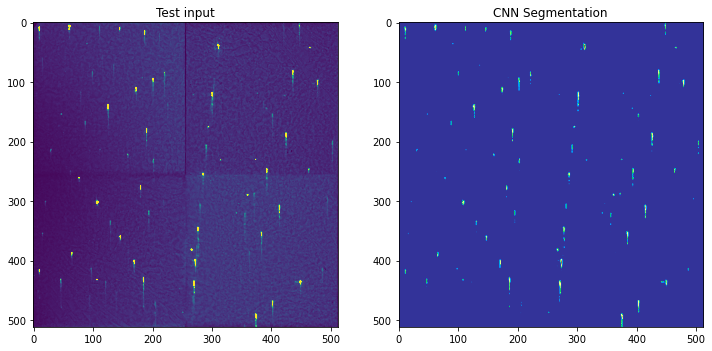

nb_conv: 40
size_conv: 6
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


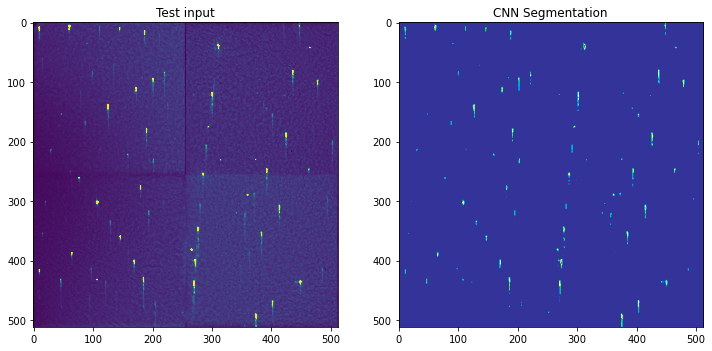

nb_conv: 40
size_conv: 6
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


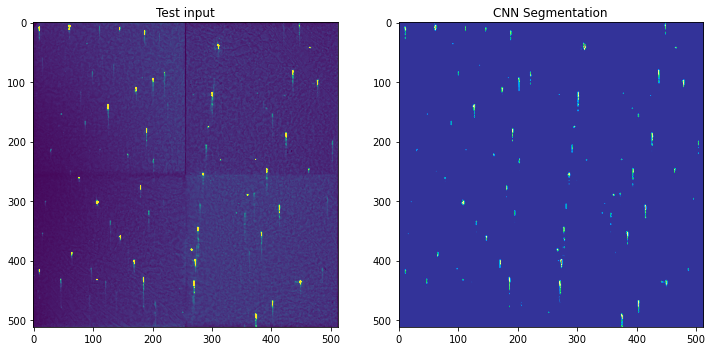

nb_conv: 40
size_conv: 9
nb_down: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


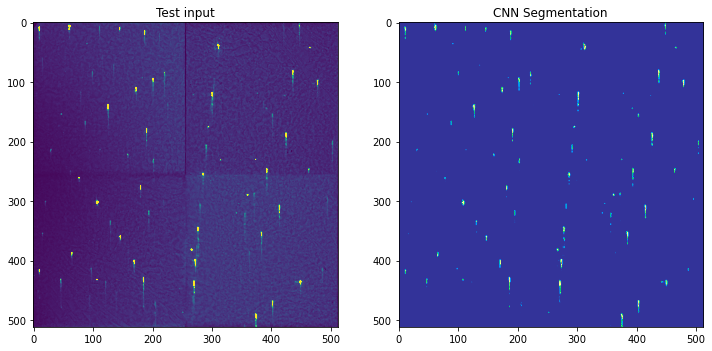

nb_conv: 40
size_conv: 9
nb_down: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


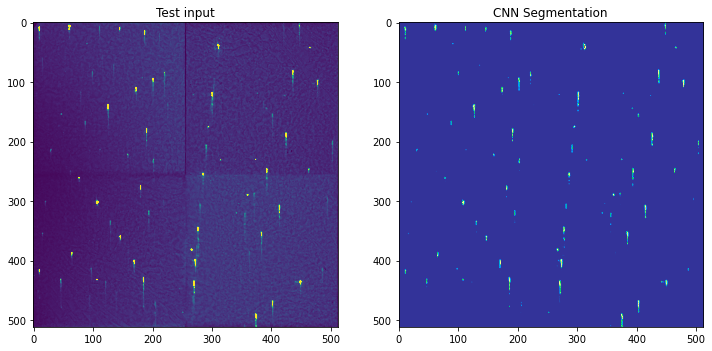

nb_conv: 40
size_conv: 9
nb_down: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


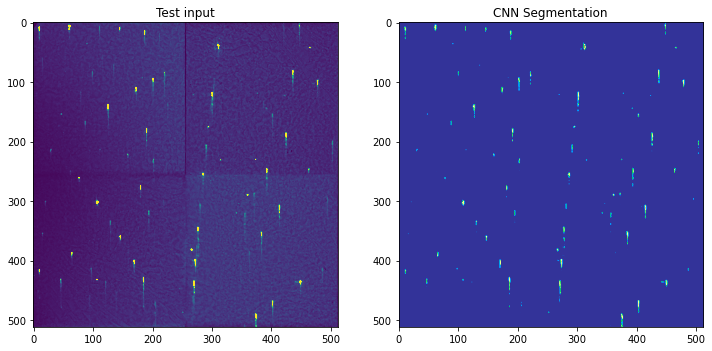

In [52]:
import copy
import os
# segmentation for the testing data
seg_path = '/home/yuehengz/xlearn/test/test_data/evaluation'
for i in range(len(df)):
    print("nb_conv:",df.loc[i]['nb_conv'])
    print("size_conv:",df.loc[i]['size_conv'])
    print("nb_down:",df.loc[i]['nb_down'])
    seg_predict(img_test, '/home/yuehengz/xlearn/test/test_data/weights/weights_seg_%s.h5'%i, seg_path,patch_size=32, patch_step=1, nb_conv=df.loc[i]['nb_conv'],
    size_conv=df.loc[i]['size_conv'], batch_size=4000, nb_epoch=nb_epoch, nb_down=df.loc[i]['nb_down'],
    nb_gpu=4)
    img_prd = copy.copy(dxchange.read_tiff(seg_path+'seg.tiff'))
    tfile.imsave(f'seg_{i}.tif',img_prd)
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(img_test,vmax=10000)#,vmax=6000)
    plt.title('Test input')
    plt.subplot(1,2,2)
    plt.imshow(img_prd, cmap='terrain',vmin=0,vmax=2)
    plt.title('CNN Segmentation')
    plt.show()
    os.remove(seg_path+'seg.tiff')

## Model evaluation

By comparison of different images manually, we find there are 6 sets of parameters which can return us one missing peaks(1.nb_conv=32, size_conv=3, nb_down=2; 2.nb_conv=32, size_conv=6, nb_down=1; 3.nb_conv=36, size_conv=3, nb_down=1; 4.nb_conv=36, size_conv=3, nb_down=2; 5.nb_conv=40, size_conv=6, nb_down=2; 6.nb_conv=40, size_conv=9, nb_down=1). It was very hard for us to choose the best one from those 6 sets of parameters by eyes. Thus, we need to introduce other benchmark for us to choose the best segmentation result and then decide the best parameters.

In x-ray science, the peak positions are crucial to us. Each peak has a different shape, we should calculate the center-of-mass of each peak and regard it as the peak positions. The easiest way to accomplish this goal is to use scipy.ndimage.measurements which have some function called label,find_objects,center_of_mass. Then, we should calculate the distance between the peak positions of manually picked up peaks and peak positions of each segmented image.

In [51]:
from scipy.ndimage.measurements import label,find_objects,center_of_mass
from scipy.spatial.distance import cdist
# this helper function calculate the distance between measured peak positions and segmented peak positions
def loss_function_distance(measure,seg):
    '''
    Input:
    # measure: 2d array: image from the measurement 
    # seg: 2d array: segmented image
    Output:
    # calculated distance 
    '''
    # measure: 2d array: image from the measurement 
    # seg: 2d array: segmented image
    
    d = cdist(measure, seg, metric='euclidean')
    indx_min = np.argmin(d, axis=1)
    distance_sum = 0
    for k in range(len(d)):
        distance_sum += d[k][indx_min[k]]
    return distance_sum / len(d)

# this helper function calculate the peak positions for a binary image.
def peak_postion(binary):
    #Input: 2d array of image
    #Output: a list of peak positions
    o_frame = binary[:,:]
    labels, num_feature = label(o_frame)   #find all clusters that could be peaks 
    locations = find_objects(labels)
    lPos = center_of_mass(o_frame,labels = labels,index=range(1,num_feature+1))
    lPos = [(pos[1],pos[0]) for pos in lPos]
    xy = []
    for center in lPos:
        xy.append([center[0],center[1]])
    return xy


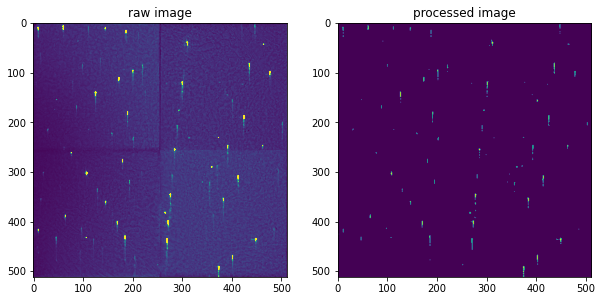

In [54]:
# calculate the positions of the raw iamge
img = tfile.imread('/home/yuehengz/xlearn/test/test_data/Staff21-1h_S0032_00027.tif')
img[np.where(np.isnan(img)==True)] = 0.
img[np.where(np.isinf(img)==True)] = 0.

threshold = 5e3 
processed = copy.copy(img)
processed[processed<threshold] = 0
# Thresholding. You're gonna have to change this stuff
processed[processed>0] = 1
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img,vmin=0,vmax=1e4)
plt.title('raw image')
plt.subplot(1,2,2)
plt.imshow(processed,vmax=1)
plt.title('processed image')
plt.show()

y = peak_postion(processed) ## the peak positions of the raw image

In [74]:
# calculate the loss of each segmentation model
loss_c = 1e10
idx = -1
for i in range(len(df)):
    seg_img = tfile.imread(f'seg_{i}.tif')
    peak_seg =  peak_postion(seg_img)
    loss = loss_function_distance(y,peak_seg)
    df.loc[i]['distance error'] = loss
    if loss<loss_c:
        loss_c = loss
        idx = i
print("the best model is",idx)
print("nb_conv:",df.loc[idx]['nb_conv'])
print("size_conv:",df.loc[idx]['size_conv'])
print("nb_down:",df.loc[idx]['nb_down'])

<ipython-input-74-fda98c9a1743>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i]['distance error'] = loss


the best model is 16
nb_conv: 36.0
size_conv: 9.0
nb_down: 1.0


Lets plot the best segmentation result from model.

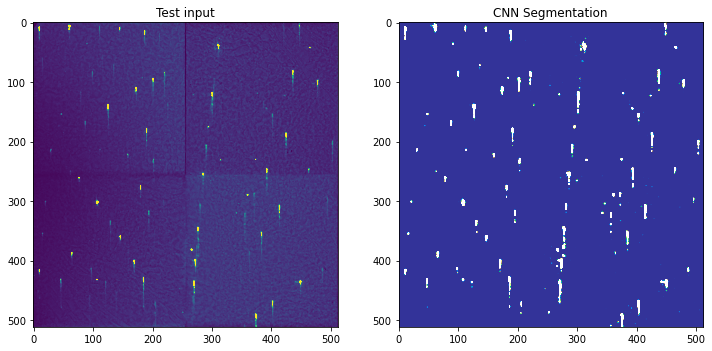

In [66]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img_test,vmax=10000)#,vmax=6000)
plt.title('Test input')
plt.subplot(1,2,2)
seg_img = tfile.imread(f'seg_16.tif')
plt.imshow(seg_img, cmap='terrain',vmin=0,vmax=0.01)
plt.title('CNN Segmentation')
plt.show()

As we can see, the best model can find some missing peaks (eg.red circles) and maintain good shape of each peak. 
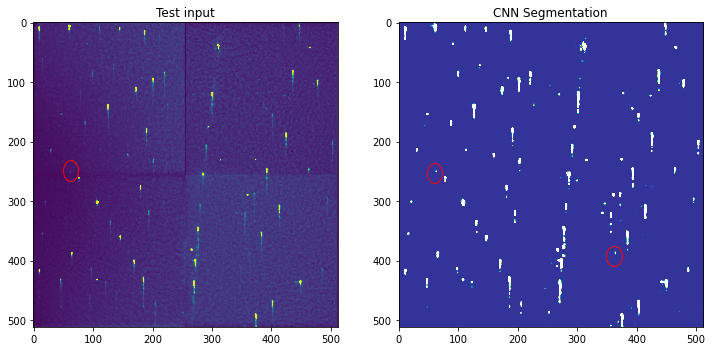

We can also check the data and average distance error via dataframe.

In [72]:
df

nb_conv  size_conv  nb_down  distance error
0        32          3        0        3.104455
1        32          3        1        3.082681
2        32          3        2        2.874099
3        32          6        0        2.883816
4        32          6        1        3.003601
5        32          6        2        3.352267
6        32          9        0        3.020656
7        32          9        1        3.001281
8        32          9        2        2.960162
9        36          3        0        3.183291
10       36          3        1        2.914758
11       36          3        2        3.362111
12       36          6        0        3.336559
13       36          6        1        3.216677
14       36          6        2        2.957202
15       36          9        0        2.743590
16       36          9        1        2.700704
17       36          9        2        2.893773
18       40          3        0        3.064277
19       40          3        1        3.185457
20       40          3        2        2.977246
21       40          6        0        3.244654
22       40          6        1        2.826893
23       40          6        2        2.994739
24       40          9        0        2.989384
25       40          9        1        2.959287
26       40          9        2        3.044285

### Summary and further resources

This tutorial introduced how to process and analyze x-ray diffraction images using tensorflow, feature extraction and scipy. We highlighted the process of choosing/modifying the parameters for models and estimate the performance of models (which is a significant aspect in data science). Much more detail about the libraries and questions on Xlearn and feature extraction  are available from the following links.

1. Xlearn: https://xlearn.readthedocs.io/en/latest/source/api/xlearn.segmentation.html
2. Convolutional neural network (CNN): Y. Lecun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the Ieee, 86(11):2278–2324, 1998. doi:10.1109/5.726791.
3. feature extraction: C. Shashank Kaira, Xiaogang Yang, Vincent De Andrade, Francesco De Carlo, William Scullin, Doga Gursoy, and Nikhilesh Chawla. Automated correlative segmentation of large transmission x-ray microscopy (txm) to- mograms using deep learning. Materials Characterization, 142:203–210, 2018. URL: https://www.sciencedirect. com/science/article/pii/S1044580318301906, doi:https://doi.org/10.1016/j.matchar.2018.05.053.
4. tensorflow: https://www.tensorflow.org/
5. scipy: https://www.scipy.org/
6. X-ray diffraction and CNN : Xiaogang Yang, Vincent De Andrade, William Scullin, Eva L. Dyer, Narayanan Kasthuri, Francesco De Carlo, and Dog ̆a Gürsoy. Low-dose x-ray tomography through a deep convolutional neural network. Scientific Reports, 8(1):2575, 2018. URL: https://doi.org/10.1038/s41598-018-19426-7https://www.ncbi.nlm.nih.gov/pmc/articles/ PMC5803233/pdf/41598_2018_Article_19426.pdf, doi:10.1038/s41598-018-19426-7.